# Phishing Email Detection

### Import all the libraries

In [2]:
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load the dataset and analyse

In [ ]:
# Load the dataset
df = pd.read_csv('phishing_email.csv')

# Display the first few rows of the dataset
print(df.head())

# Check the distribution of labels
print('--------------\nLabels:')
print(df['label'].value_counts())

# Check for missing values
print('--------------\nNull Values:')
print(df.isnull().sum())

df = df.dropna(subset=['label'])



                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0
--------------
Labels:
label
1    42891
0    39595
Name: count, dtype: int64
--------------
Null Values:
text_combined    0
label            0
dtype: int64


### Text Vectorization

In [4]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=3000)

# Transform the text data
X = vectorizer.fit_transform(df['text_combined']).toarray()
y = df['label']




### Split data to train and test datasets

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### First Model - Logistic Regression

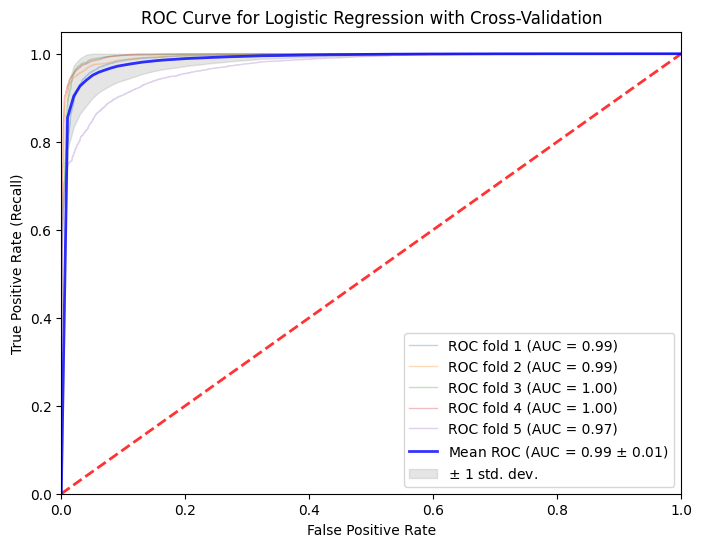

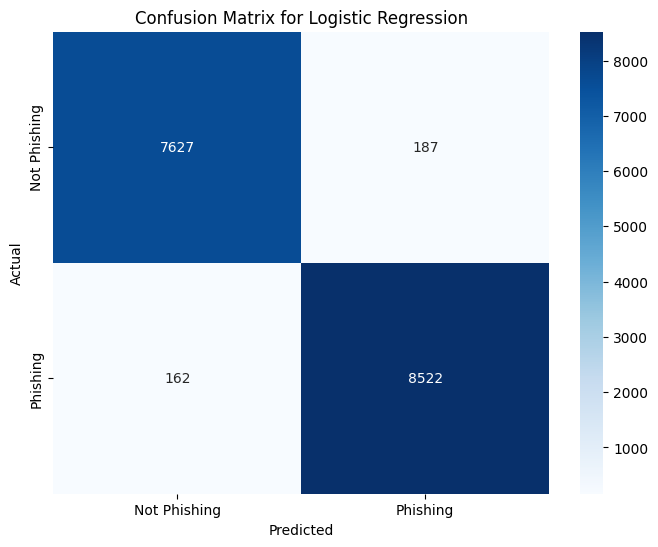

Accuracy: 0.9788459207176627
Precision: 0.9785279595820415
Recall: 0.9813450023030862
F1-Score: 0.9799344563905019


In [6]:
# Define the model
logreg = LogisticRegression()
logreg_cv = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = logreg_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Logistic Regression with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



### Second Model - Random Forest

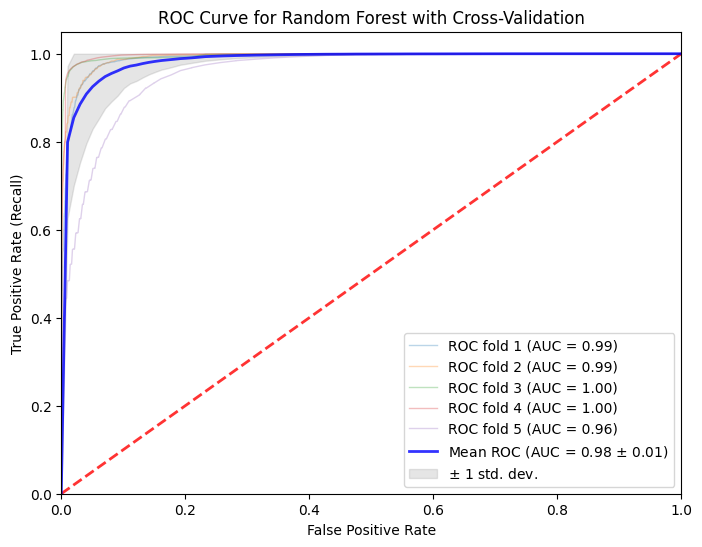

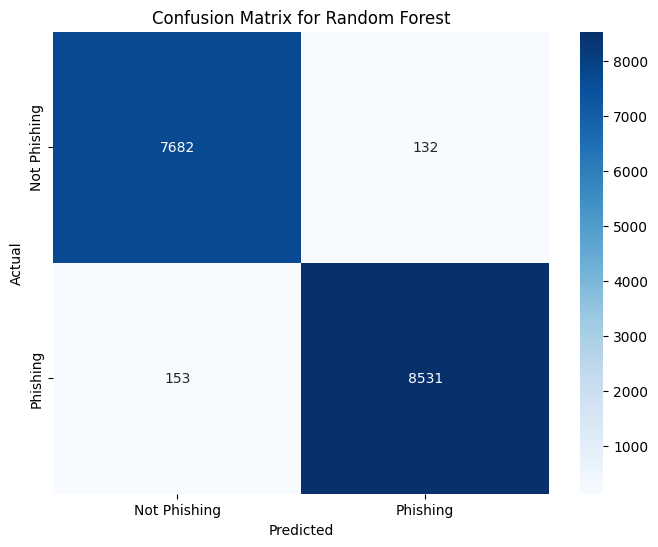

Accuracy: 0.9827251788095527
Precision: 0.9847627842548771
Recall: 0.9823813910640258
F1-Score: 0.9835706462212487


In [7]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model_cv = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

tprs_rf = []
aucs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

# Perform cross-validation and plot the ROC curve for each fold
for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = rf_model_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr_rf, tpr_rf, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs_rf.append(np.interp(mean_fpr_rf, fpr_rf, tpr_rf))
    tprs_rf[-1][0] = 0.0
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs_rf.append(roc_auc_rf)
    plt.plot(fpr_rf, tpr_rf, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rf, std_auc_rf), lw=2, alpha=0.8)

std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Random Forest with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Evaluate the model trained with complete dataset
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1-Score: {f1_rf}')


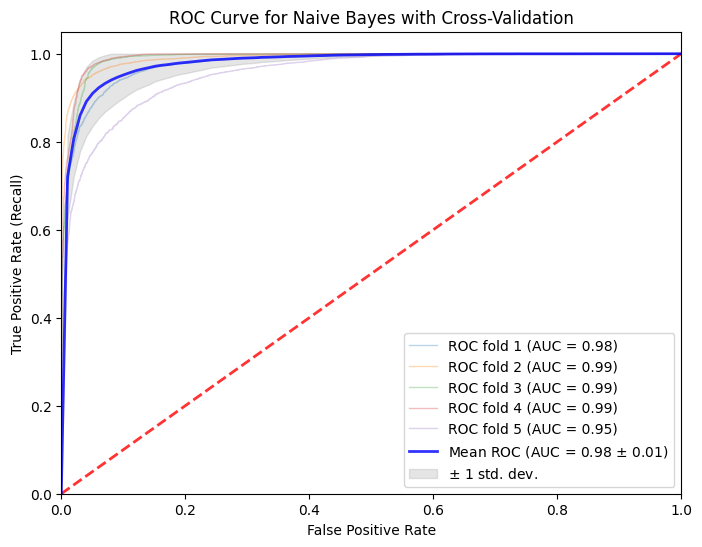

Naive Bayes Accuracy: 0.953388289489635
Naive Bayes Precision: 0.9761761520875948
Naive Bayes Recall: 0.9342468908337171
Naive Bayes F1-Score: 0.954751397469844


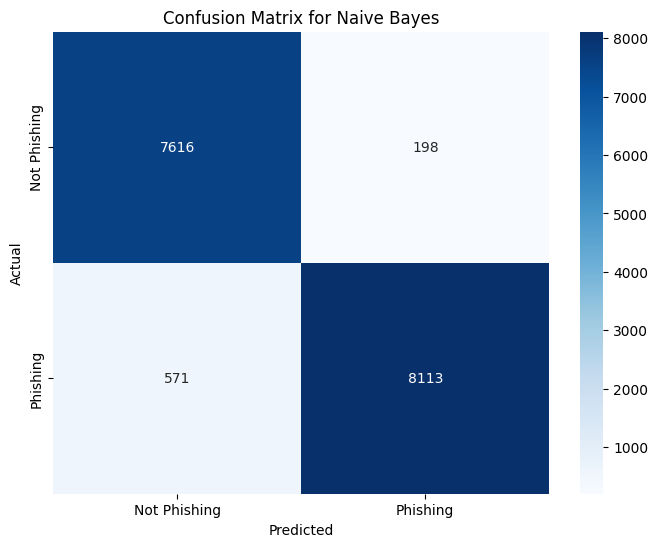

In [8]:
# Create the Naive Bayes model
nb_model = MultinomialNB()
nb_model_cv = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]

tprs_nb = []
aucs_nb = []
mean_fpr_nb = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = nb_model_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr_nb, tpr_nb, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs_nb.append(np.interp(mean_fpr_nb, fpr_nb, tpr_nb))
    tprs_nb[-1][0] = 0.0
    roc_auc_nb = auc(fpr_nb, tpr_nb)
    aucs_nb.append(roc_auc_nb)
    plt.plot(fpr_nb, tpr_nb, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
plt.plot(mean_fpr_nb, mean_tpr_nb, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb), lw=2, alpha=0.8)

std_tpr_nb = np.std(tprs_nb, axis=0)
tprs_upper_nb = np.minimum(mean_tpr_nb + std_tpr_nb, 1)
tprs_lower_nb = np.maximum(mean_tpr_nb - std_tpr_nb, 0)
plt.fill_between(mean_fpr_nb, tprs_lower_nb, tprs_upper_nb, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Naive Bayes with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f'Naive Bayes Accuracy: {accuracy_nb}')
print(f'Naive Bayes Precision: {precision_nb}')
print(f'Naive Bayes Recall: {recall_nb}')
print(f'Naive Bayes F1-Score: {f1_nb}')

# Compute the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()


### Phishing Detection Application

In [9]:
def predict_phishing(email_body, model, vectorizer):
    """
    Predicts whether an email is a phishing email.

    Parameters:
    email_body (str): The body of the email to classify.
    model: The trained machine learning model.
    vectorizer: The vectorizer used to transform the text data.

    Returns:
    str: 'Phishing' if the email is a phishing email, otherwise 'Not Phishing'.
    """

    # Preprocess the email body (assuming similar preprocessing used during training)
    def preprocess_text(text):
        text = re.sub('[^a-zA-Z\s]', '', text)
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    # Preprocess the email body
    processed_email = preprocess_text(email_body)

    # Transform the email body using the trained vectorizer
    email_vector = vectorizer.transform([processed_email])

    # Predict the label using the model
    prediction = model.predict(email_vector)

    # Return the result
    return 'Phishing' if prediction[0] == 1 else 'Not Phishing'


In [10]:
email_phishing = "Dear Customer, Your account has been compromised. Please click the link below to verify your identity and secure your account: https://www.clickme.com"
email_non_phishing = "Hello Team, Please find attached the meeting minutes from yesterday's discussion. Looking forward to your feedback."

# Models
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf_model,
    "Naive Bayes": nb_model
}

# Predict results
results = []

for model_name, model in models.items():
    result_phishing = predict_phishing(email_phishing, model, vectorizer)
    result_non_phishing = predict_phishing(email_non_phishing, model, vectorizer)
    results.append([model_name, result_phishing, result_non_phishing])

# Display results in a table
import pandas as pd

results_df = pd.DataFrame(results, columns=["Model", "Phishing Email Result", "Non-Phishing Email Result"])
print(results_df.to_markdown(index=False))


| Model               | Phishing Email Result   | Non-Phishing Email Result   |
|:--------------------|:------------------------|:----------------------------|
| Logistic Regression | Phishing                | Not Phishing                |
| Random Forest       | Phishing                | Not Phishing                |
| Naive Bayes         | Phishing                | Not Phishing                |
